In [1]:
import os, shutil, sys, random, cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from random import choice
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16


In [18]:
dataset_dividido_folder = 'brain_tumor_dataset_dividido/'

treino_folder = 'treino/'
teste_folder = 'teste/'

dataset_dividido_folder_treino = dataset_dividido_folder + treino_folder
dataset_dividido_folder_teste = dataset_dividido_folder + teste_folder


In [19]:
datagen_treino = ImageDataGenerator(rescale = 1./255,
                                    brightness_range=(0.7, 1.3),
                                    vertical_flip=True,
                                    horizontal_flip=True,
                                    validation_split = 0.25)

datagen_teste = ImageDataGenerator(rescale = 1./255)

In [20]:
seed = 123

dados_treino = datagen_treino.flow_from_directory(
    dataset_dividido_folder_treino,
    target_size = (150,150),
    #color_mode = "grayscale",
    batch_size = 1,
    class_mode="binary",
    subset='training',
    seed = seed)



dados_validacao = datagen_treino.flow_from_directory(
    dataset_dividido_folder_treino,
    target_size = (150,150),
    #color_mode = "grayscale",
    batch_size = 1,
    class_mode="binary",
    subset='validation',
    seed = seed)

dados_teste = datagen_teste.flow_from_directory(
    dataset_dividido_folder_teste,
    target_size = (150,150),
    #color_mode = "grayscale",
    batch_size = 1,
    class_mode = 'binary'
    )

Found 145 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


In [26]:
base_model = VGG16(
    include_top=False, 
    input_shape=(150,150,3)
)

58892288/58889256 [==============================] - 7s 0us/step


#### Aqui criamos a instância do modelo VGG16 que vamos utilizar para a criação do nosso modelo. Definimos o include_top em false para não utilizarmos as 3 camadas totalmente conectadas na parte superior da rede e passamos também o input shape do modelo. Apesar deste modelo ter como entrada padrão imagens 224x224, utilizando as resoluções das imagens que temos vindo a utilizar (150x150) obtivemos melhores resultados do que utilizar a resolução padrão do modelo.

In [49]:

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 8193      
Total params: 14,722,881
Trainable params: 8,193
Non-trainable params: 14,714,688
_________________________________________________________________


#### O modelo que criamos é Sequencial dando como primeira camada o VGG16, seguido de uma camada Flatten para colocar o output shape num vetor de uma dimensão, para posteriormente se ligar à camada Densa de output. No meio destas duas camdas colocou-se uma camada de dropout para reduzir o overfitting. Depois desativamos o treino na primeira camada do modelo (VGG16) pois esses pesos já foram anteriormente calculados (pesos pré-treinados no ImageNet), a ideia é reutilizar os mesmos, poupando também tempo de processamento.

In [50]:
early = EarlyStopping(monitor='val_accuracy', mode='max', patience=10
)

history = model.fit_generator(
    dados_treino,
    steps_per_epoch=30,
    epochs=30,
    validation_data=dados_validacao,
    validation_steps=20,
    callbacks=[early]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 30 steps, validate for 20 steps
Epoch 1/30
30/30 [==============================] - 5s 182ms/step - loss: 0.7993 - accuracy: 0.5667 - val_loss: 0.5782 - val_accuracy: 0.6500
Epoch 2/30
30/30 [==============================] - 4s 124ms/step - loss: 0.5991 - accuracy: 0.5667 - val_loss: 0.8017 - val_accuracy: 0.5500
Epoch 3/30
30/30 [==============================] - 4s 133ms/step - loss: 0.5696 - accuracy: 0.8000 - val_loss: 0.4413 - val_accuracy: 0.8000
Epoch 4/30
30/30 [==============================] - 4s 129ms/step - loss: 0.4472 - accuracy: 0.8000 - val_loss: 0.3716 - val_accuracy: 0.9000
Epoch 5/30
30/30 [==============================] - 4s 126ms/step - loss: 0.4875 - accuracy: 0.7667 - val_loss: 0.3146 - val_accuracy: 0.8500
Epoch 6/30
30/30 [==============================] - 4s 125ms/step - loss: 0.2902 - accuracy: 0.9667 - val_loss: 0.2798 - val_accuracy: 0.9500
Epoch 7/30
30/30 [==============================] - 4s 1

#### Para efetuarmos o fit do modelo definimos steps_per_epoch (Número total de etapas (lotes de amostras) a produzir a partir do `generator` antes de declarar uma época por terminada e começar a seguinte) igual a 30, foi definido o número de épocas igual a 30, dados de validação e os validations_steps. Foi utilizado também o callback early stopping com tolerância de 10 para o valor de val_accuracy.

In [51]:
scores = model.evaluate(dados_teste, verbose = 0)
print("Accuracy: ", scores[1] * 100)

  ...
    to  
  ['...']
Accuracy:  82.8125


### Obtivemos perto de 83% de accuracy nos dados de teste, sendo um resultado muito positivo para o dataset em questão. 

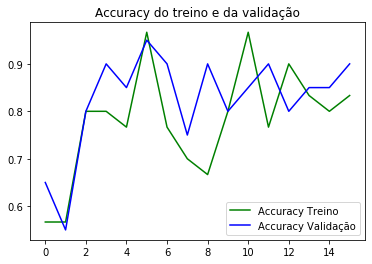

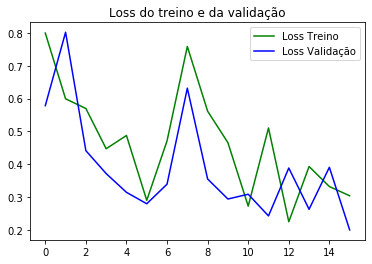

In [52]:
#Visualizar gráficos
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

#Gráfico Accuracy
plt.plot(epochs, accuracy, 'b', color = 'green', label = 'Accuracy Treino')
plt.plot(epochs, val_accuracy, 'b', label = 'Accuracy Validação')
plt.title('Accuracy do treino e da validação')
plt.legend()
plt.figure()

#Gráfico Loss
plt.plot(epochs, loss, 'b', color = 'green', label = 'Loss Treino')
plt.plot(epochs, val_loss, 'b', label = 'Loss Validação')
plt.title('Loss do treino e da validação')
plt.legend()
plt.show()

#### Nesta célula podemos verificar as curvas de accuracy de treino e validação no primeiro gráfico. Após vários testes, este foi o melhor resultado obtido para este modelo, mesmo as curvas não ilustrarem grande linearidade na accuracy quer nos dados de treino quer nos dados de validação. No segundo gráfico podemos verificar as curvas de loss de treino e validação. Tal como as curvas de accuracy, o modelo não tem grande linearidade nas curvas de loss. Para o dataset em questão, com as adversidade que contém estas curvas tornam-se bastantes razoáveis.  